# Implementación de Resnet 18 con Keras

## Instalación de dependencias

In [1]:
%pip install numpy pandas matplotlib tensorflow scikit-learn setuptools


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Preprocesaimento

In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers


2024-11-06 15:40:33.905372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 15:40:33.924081: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 15:40:34.139290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 15:40:34.279546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730929234.404369   26732 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730929234.44

Cargar datos (para imágenes de manos)

In [3]:
# Define target size for images
TARGET_HEIGHT = 372  # Adjust as needed
TARGET_WIDTH = 372    # Adjust as needed

def parse_tfrecord_fn(example):
    # Define features based on the TFRecord schema
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),  # Encoded image
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64)  # Label
    }
    # Parse the example
    parsed_example = tf.io.parse_single_example(example, feature_description)

    # Decode image from JPEG format and resize
    image = tf.io.decode_jpeg(parsed_example['image/encoded'])
    image = tf.image.resize(image, [TARGET_HEIGHT, TARGET_WIDTH])  # Resize to target shape
    label = parsed_example['image/object/class/label']
    
    return image, label



def load_data_as_tensors(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_fn)
    images, labels = [], []
    for image, label in dataset:
        images.append(image)
        labels.append(label)
    images = tf.stack(images)  # This should now work
    labels = tf.stack(labels)   # This should now work
    return images, labels



# Paths to your TFRecord files
train_path = "data/train/Letters.tfrecord"
test_path = "data/test/Letters.tfrecord"
valid_path = "data/valid/Letters.tfrecord"

# Load and split data
X_train, Y_train = load_data_as_tensors(train_path)
X_test, Y_test = load_data_as_tensors(test_path)
X_valid, Y_valid = load_data_as_tensors(valid_path)

# Verify the data shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)



2024-11-06 15:40:36.975073: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-06 15:40:37.211412: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-11-06 15:40:38.698812: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-06 15:40:40.588381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (1512, 372, 372, 3)
Y_train shape: (1512,)
X_test shape: (72, 372, 372, 3)
Y_test shape: (72,)
X_valid shape: (144, 372, 372, 3)
Y_valid shape: (144,)


Cargar datos (para imágenes de animales)

In [4]:
# Cargar datos de CIFAR10
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


Imagen de ejemplo

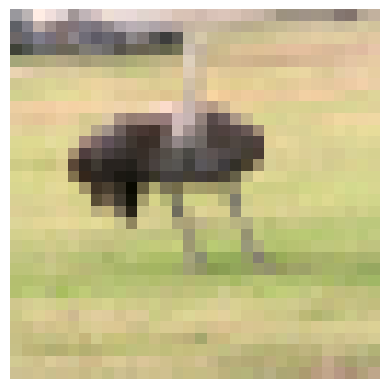

In [5]:
import matplotlib.pyplot as plt

# Normalize image for display
def normalize_image(image):
    return (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))

# Normalize the specific image before showing
normalized_image = normalize_image(X_train[42])

# Display the image
plt.imshow(normalized_image)
plt.axis('off')  # Hide axis ticks
plt.show()


In [6]:
    # Assuming X_train and X_test are your image tensors
    X_train = tf.cast(X_train, tf.float32)  # Cast to float32
    X_test = tf.cast(X_test, tf.float32)    # Cast to float32

    # Normalize to [0, 1]
    X_train /= 255.0
    X_test /= 255.0


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train_np = X_train.numpy() if hasattr(X_train, 'numpy') else X_train
Y_train_np = Y_train.numpy() if hasattr(Y_train, 'numpy') else Y_train

X_train, X_val, Y_train, Y_val = train_test_split(X_train_np, Y_train_np, test_size=0.2, shuffle=True)


In [8]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

## Aumento de datos

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

## Implementación de ResNet-18

Extraído de [Github](https://github.com/songrise/CNN_Keras)

In [10]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out



Configuración del modelo

In [11]:
# Inicializar el modelo ResNet18 con 10 clases de salida
model = ResNet18(10)

# Construir el modelo especificando la forma de entrada (32x32 píxeles y 3 canales de color, sin especificar el tamaño del lote)
model.build(input_shape=(None, 32, 32, 3))

# Usar la función de pérdida 'categorical_crossentropy' ya que las etiquetas están en formato one-hot encoded
# 'categorical_crossentropy' es ideal para clasificaciones múltiples con etiquetas codificadas de esta manera
# use categorical_crossentropy since the label is one-hot encoded

# Importar el optimizador SGD de Keras
from keras.optimizers import SGD

# Configuración opcional del optimizador SGD con parámetros sugeridos por el investigador Kaiming He:
# opt = SGD(learning_rate=0.1, momentum=0.9, decay=1e-04) # Parámetros sugeridos por He [1]

# Compilar el modelo usando el optimizador "adam", con la función de pérdida 'categorical_crossentropy' y la métrica de precisión
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

# Mostrar un resumen de la arquitectura del modelo
model.summary()


/home/nahtie/Desktop/liese/liese-openvino/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'res_net18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "res_net18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block (ResnetBlock)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_1 (ResnetBlock)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_2 (ResnetBlock)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_3 (ResnetBlock)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_4 (ResnetBlock)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_5 (ResnetBlock)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_6 (ResnetBlock)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_7 (ResnetBlock)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamiento

In [12]:
from keras.callbacks import EarlyStopping

#es = EarlyStopping(patience=8, restore_best_weights=True, monitor="accuracy", mode="max")
# No se usó validación cruzada debido a la limitación de recursos computacionales
STEPS = len(X_train) // 256
# history = model.fit(aug.flow(X_train, Y_train, batch_size=256), steps_per_epoch=STEPS, batch_size=256, epochs=5, validation_data=(X_train, Y_train), callbacks=[es])
history = model.fit(aug.flow(X_train, Y_train, batch_size=256), steps_per_epoch=STEPS, batch_size=256, epochs=3, validation_data=(X_train, Y_train))


/home/nahtie/Desktop/liese/liese-openvino/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 603ms/step - accuracy: 0.2373 - loss: 2.6634 - val_accuracy: 0.4534 - val_loss: 1.4860
Epoch 2/3
  1/156 ━━━━━━━━━━━━━━━━━━━━ 1:06 430ms/step - accuracy: 0.4141 - loss: 1.5473

2024-11-06 15:42:27.563135: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.4141 - loss: 1.5473 - val_accuracy: 0.4478 - val_loss: 1.5054
Epoch 3/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 91s 582ms/step - accuracy: 0.4601 - loss: 1.4743 - val_accuracy: 0.5183 - val_loss: 1.3430


## Curva de aprendizaje por época

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


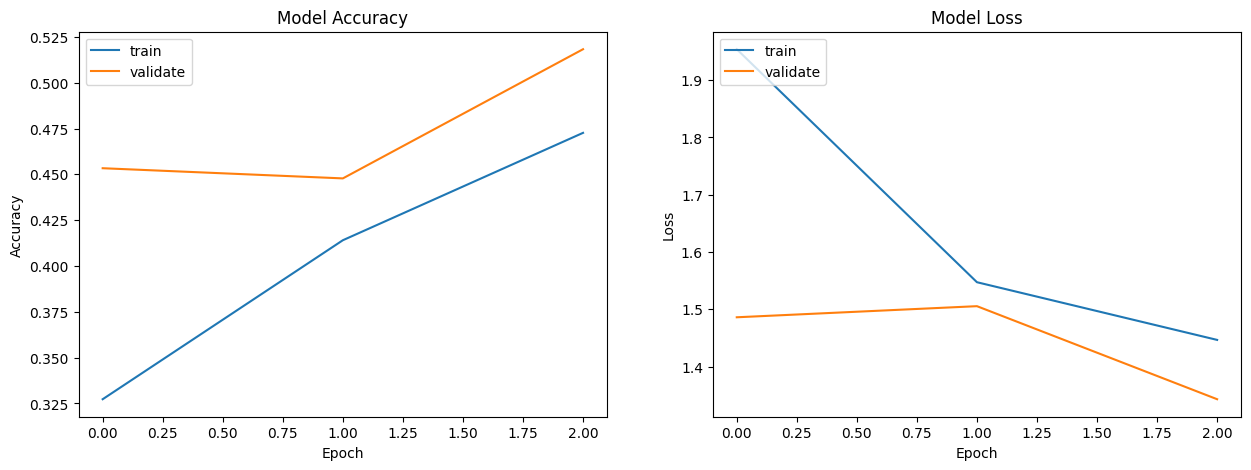

In [13]:

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # Describir el historial de entrenamiento
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # Describir las pérdidas
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# Mostrar la data histórica
print(history.history.keys())
plotmodelhistory(history)


##  Predicción

In [14]:
## Evaluar el modelo en el conjunto de prueba

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5204 - loss: 1.3394
Model Loss is 1.3429839611053467
Model Accuracy is 0.5182750225067139


## Conversión a formato IX para OpenVINO

In [15]:
import openvino as ov

In [16]:
X_train[0]

array([[[0.6117647 , 0.65882355, 0.5882353 ],
        [0.64705884, 0.7019608 , 0.627451  ],
        [0.67058825, 0.7294118 , 0.654902  ],
        ...,
        [0.19215687, 0.16470589, 0.1254902 ],
        [0.1764706 , 0.14509805, 0.11372549],
        [0.1882353 , 0.15686275, 0.11372549]],

       [[0.3019608 , 0.33333334, 0.2627451 ],
        [0.36862746, 0.4117647 , 0.3254902 ],
        [0.4745098 , 0.5254902 , 0.4117647 ],
        ...,
        [0.34901962, 0.28627452, 0.22352941],
        [0.28627452, 0.22745098, 0.17254902],
        [0.29411766, 0.23529412, 0.1764706 ]],

       [[0.28235295, 0.3019608 , 0.29411766],
        [0.24705882, 0.2784314 , 0.24705882],
        [0.30980393, 0.3529412 , 0.2784314 ],
        ...,
        [0.5372549 , 0.4862745 , 0.39607844],
        [0.4392157 , 0.39607844, 0.3137255 ],
        [0.3764706 , 0.34117648, 0.25490198]],

       ...,

       [[0.3137255 , 0.3647059 , 0.2901961 ],
        [0.30980393, 0.36862746, 0.28235295],
        [0.2627451 , 0

In [17]:
# Create tensor example with X_train image
input_tensor = tf.convert_to_tensor(X_train)

In [20]:
# Create OpenVINO model
X_train = tf.cast(X_train, tf.float32)  # Cast to float32

example_input = tf.convert_to_tensor(X_train[:1], dtype=tf.float32)  # Use a batch size of 1
ov_model = ov.convert_model(model, example_input=example_input)

In [21]:
# Save the OpenVINO model
ov.save_model(ov_model, 'resnet18_openvino_model.xml')

print("Model saved as 'resnet18_openvino_model.xml'")